Prueba desempeño
Parámetros de la prueba: 

Arquitectura: VGG16

Datos:skin-cancer-malignant-vs-benign

Data Augmentation: No

K-Fold Validation: No

Hyperparameter Tuning: No

Parámetros estáticos de entrenamiento:


lr = 1e-5

init = 'normal'

activ = 'relu'

activ_last = 'softmax'

optim = 'adam'

epochs = 50

 batch_size = 64


In [1]:
# Librerias Basicas 
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os
import seaborn as sns
import itertools
from glob import glob
from PIL import Image
import PIL.Image
from IPython.display import Image

In [2]:
# Librerias de preprocesamiento y metricas
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

In [4]:
# Librerias para backend, arquitectura y entrenamiento
import keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras.layers.core import Activation
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

In [5]:
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"dianamerchanuis","key":"2218e75dd31a7dba96e741fd50c2a026"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 98% 317M/325M [00:08<00:00, 51.8MB/s]
100% 325M/325M [00:09<00:00, 37.3MB/s]


In [6]:
! unzip skin-cancer-malignant-vs-benign.zip ;

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: data/train/benign/420.jpg  
  inflating: data/train/benign/421.jpg  
  inflating: data/train/benign/422.jpg  
  inflating: data/train/benign/423.jpg  
  inflating: data/train/benign/424.jpg  
  inflating: data/train/benign/425.jpg  
  inflating: data/train/benign/426.jpg  
  inflating: data/train/benign/429.jpg  
  inflating: data/train/benign/43.jpg  
  inflating: data/train/benign/430.jpg  
  inflating: data/train/benign/431.jpg  
  inflating: data/train/benign/432.jpg  
  inflating: data/train/benign/434.jpg  
  inflating: data/train/benign/435.jpg  
  inflating: data/train/benign/438.jpg  
  inflating: data/train/benign/439.jpg  
  inflating: data/train/benign/440.jpg  
  inflating: data/train/benign/441.jpg  
  inflating: data/train/benign/442.jpg  
  inflating: data/train/benign/443.jpg  
  inflating: data/train/benign/445.jpg  
  inflating: data/train/benign/446.jpg  
  inflating: data/train/benign/447.jpg

In [8]:
# identificar las rutas y los nombres de las carpetas
folder_benign_train = '../content/data/train/benign'
folder_malignant_train = '../content/data/train/malignant'

folder_benign_test = '../content/data/test/benign'
folder_malignant_test = '../content/data/test/malignant'

read = lambda imname: np.asarray(PIL.Image.open(imname).convert("RGB"))

# cargar las imagenes de train 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Cargar las imagenes de test
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Crear etiquetas
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

# Crear datos combinados para train y test 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Randomizar los datos
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

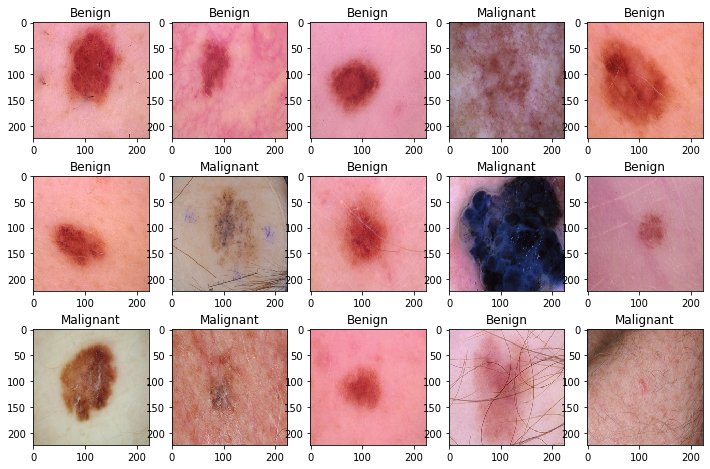

In [9]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()


In [10]:
# Etiquetas a categoricas 
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

# Normalización 
X_train = X_train/255.
X_test = X_test/255.

# crear modelo VGG16

In [11]:
base_model=VGG16(input_shape = (224,224,3), weights='imagenet',include_top=False) # importar mobilenet y descartar la ultima capa

#image_input = Input(shape=(width_shape, height_shape, 3))
#model2 = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

x=base_model.output
x = Flatten()(x)
#x=GlobalAveragePooling2D()(x)
#x=Dense(1024,activation='relu')(x) 
#x=Dense(1024,activation='relu')(x) 
#x=Dense(512,activation='relu')(x) 
preds=Dense(2,activation='softmax')(x) 

model=Model(inputs=base_model.input,outputs=preds)
Model.summary(model)

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________________________________

In [ ]:
input_shape = (224,224,3)
lr = 1e-3
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 40
batch_size = 64

model.compile(optimizer = optim ,loss = "binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_split=0.2, epochs= epochs, batch_size= batch_size, verbose=1)                


Epoch 1/40
33/33 [==============================] - 3004s 91s/step - loss: 8.1525 - accuracy: 0.4552 - val_loss: 8.3657 - val_accuracy: 0.4545
Epoch 2/40
33/33 [==============================] - 2985s 90s/step - loss: 8.3776 - accuracy: 0.4538 - val_loss: 8.3657 - val_accuracy: 0.4545
Epoch 3/40
33/33 [==============================] - 2974s 90s/step - loss: 8.3776 - accuracy: 0.4538 - val_loss: 8.3657 - val_accuracy: 0.4545
Epoch 4/40
18/33 [===============>..............] - ETA: 20:45 - loss: 8.4407 - accuracy: 0.4497

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()